# GSE Problem Set 4
### David Ngo

## Question 1

Using the program that calculates Geary Khamis indices that Fisher wrote, construct an example of two countries over five years with four goods in each year. Construct pseudo-data that have these properties:   
    (1) The first country grows at gross rate $1+g_1$ and the second country has no growth.  
    (2) Rach country has its own gross inflation rate $1+\pi_1$ and $1+ \pi_2$  
    (3) There are small idiosyncratic price shocks in every sector in every year.    
Implement the program and explain what you discover about real economic growth, inflation rates, and the real exchange rate. I expect a nice table summarizing your findings.  

In [1]:
# Import packages
import numpy as np
import pandas as pd
import math
from scipy import optimize as opt
import matplotlib.pyplot as plt

# Set seed for RNG
np.random.seed(13)

# Number of commodities
Goods = ['Good 1', 'Good 2', 'Good 3', 'Good 4']
N = 4
# Number of countries (5 countries over 2 years)
Names = ['Avalon','Narnia']
C = 2
# Number of years
Year_names = ['1099', '1100', '1101', '1102', '1103']
Year = 5
# There are two types of data
Type_names = ['Values','Prices']
Type = 2

In [2]:
# Construct pseudo data

# Generate uniformly distributed numbers from range 0 to q_scale
scale1 = 100
q_base = [scale1*np.random.rand(N) for i in range(int(C))]

# Crountries grow at different rates
growth = [0.04, 0.0]

# Three dimensional array with Country, Year, and Goods
quantities = [[q_base[j]*(1+growth[j])**i for i in range(int(Year))] for j in range(int(C))]

# Prices
scale = [10,50]
p_base = [scale[i]*np.random.rand(N) for i in range(int(C))]

# Inflation rates are different
inflation = [0.0, 0.05]
scale = [0.1,0.1] # determines the variance of the shocks to inflation by sector
prices = [[(p_base[j]*(1+inflation[j])**i) + (scale[j]*np.random.randn(N)) for i in range(int(Year))] for j in range(int(C))]

prices = np.array(prices)

values = prices*quantities

data = np.array([values, prices])

# Print values of each good for each country overtime (print pseudo data)
for i in range(int(C)):
    for j in range(int(Type)):
        print(Names[i],Type_names[j])
        print(pd.DataFrame (data[j,i,:,:], columns = Goods, index = Year_names))

Avalon Values
          Good 1      Good 2     Good 3      Good 4
1099  492.848258  168.512257  33.519280  285.877416
1100  526.334045  179.153448  31.126356  321.354429
1101  544.801235  185.435450  22.462267  324.184251
1102  569.624866  190.019436  31.139508  326.800492
1103  568.828488  199.868471  47.278052  318.937890
Avalon Prices
        Good 1    Good 2    Good 3    Good 4
1099  6.337235  7.094022  0.406650  2.960162
1100  6.507508  7.251917  0.363096  3.199533
1101  6.476762  7.217505  0.251949  3.103565
1102  6.511417  7.111464  0.335844  3.008280
1103  6.252224  7.192369  0.490289  2.822984
Narnia Values
          Good 1       Good 2       Good 3       Good 4
1099  289.320799  1951.750822  1131.637647  2632.681592
1100  300.888840  2042.658827  1194.610029  2756.278075
1101  306.281595  2142.802144  1249.867909  2915.239194
1102  326.265249  2247.781796  1325.655129  3051.098446
1103  336.333980  2361.922255  1378.694141  3209.832057
Narnia Prices
        Good 1     Good 2 

In [3]:
# Now we work with the pseudo data. We first break out the data

Values = data[0] 
prices = data[1] 
Quantities = values/prices 

# Concatenate everything to eliminate the dimension having to do with country
Quantities = np.concatenate([Quantities[0,:,:], Quantities[1,:,:]])
Values = np.concatenate([data[0,0,:,:],data[0,1,:,:]])

# There are N goods
# There are C*Year "countries"

c_one = np.ones((N,1)) # column vector of ones
r_ones = np.ones((1,C*Year)) #row vector of ones; keep track of country years

GDP = np.dot(Values, c_one) # matrix manipulation
World_Q = np.dot(r_ones, Quantities)

GDP_shares = Values/GDP # divide by columns
Q_shares = Quantities/World_Q # divide by rows

## See pp. 245-42 6 in Balk

M = np.zeros((C*Year,C*Year))

for i in range(C*Year):
    for j in range(C*Year):
        M[i,j] = np.dot(np.multiply(GDP_shares[i,:],Q_shares[j,:]),c_one)

I = np.identity(C*Year)
R = np.ones((C*Year,C*Year)) 
R[:0,] = 1 # see Balk 
r = np.ones(C*Year)
#r[0] = 1 # see Balk
Q_GK = np.dot(r,np.linalg.inv(M-I+R))
PPP_GK = np.transpose(GDP)/Q_GK 
World_Prices = np.divide(np.dot(Q_GK, GDP_shares),World_Q)

In [4]:
# Make tables

results = np.zeros((10,2))
results[:,0] = Q_GK
results[:,1] = PPP_GK[0,:]

# Reduce decimal points to 2
pd.options.display.float_format = '{:,.3f}'.format

Names = ['GK-Quantities', 'GK-Price levels']

country_years = ['Avalon 1099', 'Avalon 1100', 'Avalon 1101', 'Avalon 1102', 'Avalon 1103', 'Narnia 1099', 'Narnia 1100', 'Narnia 1101', 'Narnia 1102', 'Narnia 1103']

df1 = pd.DataFrame (results,columns = Names, index = country_years)

Xrate = PPP_GK[0,5:10]/PPP_GK[0,0:5] # The exchange rate defined as how many units of B currency it takes to buy one unit of A currency

Names = ['PPP Exchange Rate']

df2 = pd.DataFrame (Xrate, columns = Names, index = Year_names)
Agrowth = np.insert([(np.log(Q_GK[1:5])-np.log(Q_GK[:4]))],0,math.nan)
Bgrowth = np.insert([np.log(Q_GK[6:10])-np.log(Q_GK[5:9])],0,math.nan) 

df2['Avalon growth'] = Agrowth 
df2['Narnia growth'] = Bgrowth 
df2['Relative size of Avalon'] = Q_GK[0:5]/Q_GK[5:10]

print(df1) 
print(df2)

             GK-Quantities  GK-Price levels
Avalon 1099          0.091       10,760.396
Avalon 1100          0.095       11,161.076
Avalon 1101          0.099       10,923.672
Avalon 1102          0.103       10,900.515
Avalon 1103          0.107       10,643.781
Narnia 1099          0.101       59,303.270
Narnia 1100          0.101       62,157.590
Narnia 1101          0.101       65,315.173
Narnia 1102          0.101       68,639.197
Narnia 1103          0.101       71,957.019
      PPP Exchange Rate  Avalon growth  Narnia growth  Relative size of Avalon
1099              5.511            nan            nan                    0.900
1100              5.569          0.039         -0.000                    0.936
1101              5.979          0.039          0.000                    0.974
1102              6.297          0.039         -0.000                    1.012
1103              6.760          0.039          0.000                    1.053


In this instance, we look at the mythical land of Avalon and the magical country of Avalon in the years 1099-1103. Avalon has a growth rate of 4% while Narnia has a growth rate of 0%. The base year quantities were randomly chosen, each country were given different inflation rates, and their prices expanded each year by the same respective rates. We also had random shocks to prices to reflect relative price changes from year to year. From GK-quantities, we find that Avalon initially had less goods than Narnia but grew overtime and grew larger than Narnia while Narnia's quantity of goods remained stagnant. 

From the above graph, we can see how real economic growth affects the real exchange rate between countries. In looking at the PPP exchange rate (derived by dividing Narnia price levels by Avalon price levels for a given year), we find that Narnia's prices were big relative to Avalon's prices. In the year 1099, the PPP exchange rate 5.511 meant that a person would have to pay 5.511 times Narnia currency to buy one good in Avalon currency. Avalon's growth rate overtime results in the relative size of Avalon becoming larger than Narnia. Also, Narnia's much higher inflation rate results in greater increases price levels overtime relative to Avalon (Narnia's currency losing value relative to Avalon). Despite random shocks in prices, both the growing size of Avalon and the increasing difference in price levels between the two countries reuslts in the PPP exchange rate becaming larger overtime. By year 1103, it would cost a person 6.760 times Narnia currency to buy one good in Avalon currency. Narnia's currency became weaker relative to Narnia from 1099 to 1103.

## Question 2

Extend Fisher's code that solves for optimal savings and investment from two periods to three periods.  
Show what happens to savings in each period as the agent becomes more patient (larger $\beta$), as the agent's savings decision become more responsive to interest rate changes (smaller $\rho$), and as total factor productivity increases (larger $A$).

In [5]:
def ps4(A, beta, rho): # define the function
    Y1 = A*K0**alpha # GDP at time 1
    # utility function for a three-period model
    def f(c):
        if rho == 1:
            u = np.log(c[0]) + beta*np.log(c[1]) + (beta**2)*np.log(c[2]) # need to check
        else:
            u = (c[0]**(1-rho) + beta*c[1]**(1-rho))/(1-rho)+ (beta**2)*c[2]**(1-rho)/(1-rho) # need to check
        return -u

    def MRS(c):
        if rho ==1:
            MRS = [1/c[0], beta/c[1], (beta**2)/c[2]] # need to check
        else: 
            MRS = [c[0]**(-rho), beta*c[1]**(-rho), (beta**2)*c[2]**(-rho)] # need to check
        return MRS

    x0 = [5,5,5] # starting points
    bnds = ((0.5,200),(0.5,200), (0.5,200)) # bounds

    cons = (
        {'type': 'ineq', 'fun': lambda x: np.array([A*(Y1-x[0])**alpha-x[1]])}, # need to check
        {'type': 'ineq', 'fun': lambda x: np.array([A*(A*(Y1-x[0])**alpha-x[1])**alpha-x[2]])}  # need to check
            )
    cx = opt.minimize(f, x0, bounds=bnds, constraints = cons)
    c = cx['x']
    prices = MRS(c)
    interest_rates = [prices[0]/prices[1], prices[1]/prices[2]]
    if cx['success'] == True:
        return(interest_rates) # return interest rates
    
    return('Problem optimizing')

### What happens to savings in each period as the agent becomes more patient (larger $\beta$):

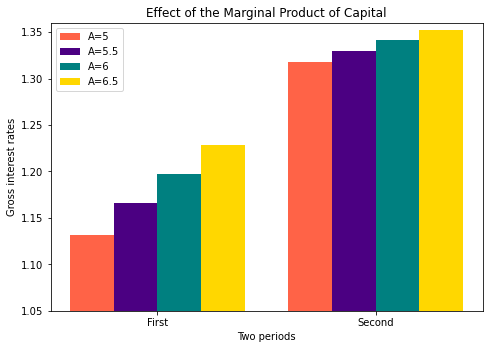

In [6]:
A = [5,5.5,6,6.5]
K0 = 2 # initial capital
alpha = 0.33 # capital's share
beta = 0.9
rho = 0.9
results1 = [ps4(a,0.9,0.9) for a in A]

data = results1
X = np.arange(2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'tomato', width = 0.2)
ax.bar(X + 0.20, data[1], color = 'indigo', width = 0.2)
ax.bar(X + 0.40, data[2], color = 'teal', width = 0.2)
ax.bar(X + 0.60, data[3], color = 'gold', width = 0.2)
ax.legend(labels=['A=5', 'A=5.5', 'A=6', 'A=6.5'])
ax.set_xlabel('Two periods')
ax.set_ylabel('Gross interest rates')
ax.set_xticks(np.arange(2)+0.3)
ax.set_xticklabels(('First', 'Second'))
ax.set_title('Effect of the Marginal Product of Capital')
ax.set_ylim(1.05, 1.36)
plt.show()

### What happens to savings in each period as the agent's savings decision become more responsive to interest rate changes (smaller $\rho$)

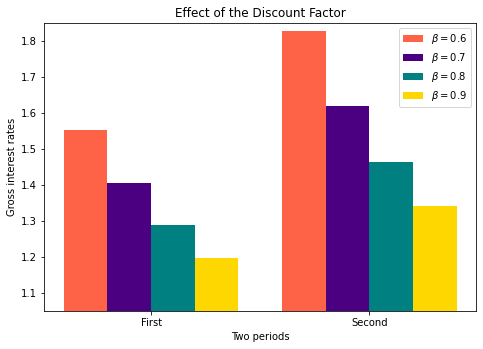

In [7]:
A = 6.0
K0 = 2 # initial capital
alpha = 0.33 # capital's share
rho = 0.9
B = [0.6, 0.7, 0.8, 0.9]
result2 = [ps4(6,beta,0.9) for beta in B]

data = result2
X = np.arange(2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'tomato', width = 0.2)
ax.bar(X + 0.20, data[1], color = 'indigo', width = 0.2)
ax.bar(X + 0.40, data[2], color = 'teal', width = 0.2)
ax.bar(X + 0.60, data[3], color = 'gold', width = 0.2)
ax.legend(labels=[r'$\beta=0.6$', r'$\beta=0.7$', r'$\beta=0.8$', r'$\beta=0.9$'])
ax.set_xlabel('Two periods')
ax.set_ylabel('Gross interest rates')
ax.set_xticks(np.arange(2)+0.3)
ax.set_xticklabels(('First', 'Second'))
ax.set_title('Effect of the Discount Factor')
ax.set_ylim(1.05, 1.85)
plt.show()

### Show what happens to savings in each period as total factor productivity increases (larger $A$).

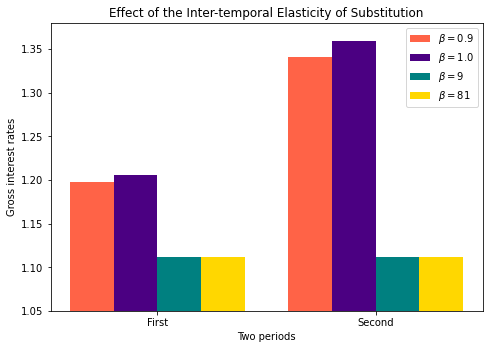

In [8]:
A = 6.0
K0 = 2 # initial capital
alpha = 0.33 # capital's share
beta = 0.9
Rho = [0.9, 1, 9, 81]
results3 = [ps4(6,0.9,r) for r in Rho]

data = results3
X = np.arange(2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(X + 0.00, data[0], color = 'tomato', width = 0.2)
ax.bar(X + 0.20, data[1], color = 'indigo', width = 0.2)
ax.bar(X + 0.40, data[2], color = 'teal', width = 0.2)
ax.bar(X + 0.60, data[3], color = 'gold', width = 0.2)

ax.legend(labels=[r'$\beta=0.9$', r'$\beta=1.0$', r'$\beta=9$', r'$\beta=81$'])
ax.set_xlabel('Two periods')
ax.set_ylabel('Gross interest rates')
ax.set_xticks(np.arange(2)+0.3)
ax.set_xticklabels(('First', 'Second'))
ax.set_title('Effect of the Inter-temporal Elasticity of Substitution')
ax.set_ylim(1.05, 1.38)
plt.show()

# Lessons learned
<ol>
    <li>One can put functions inside of a function in Python.  This feature is a big help. </li>
    <li>The optimizer doesn't always work.  It depends upon initial conditions. </li>
    <li>Higher the marginal efficiency of investment $A$ entails higher real interest rates. </li>
     <li>Higher discount factor $\beta$ entails lower real interest rates. </li>
     <li>Higher $\rho$ may entail less variability of the real interst rate across time. </li>
</ol>